<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

test-balanced.csv    train-balanced-sarcasm.csv
test-unbalanced.csv  train-balanced-sarc.csv.gz


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk

In [3]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [8]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

In [9]:
train1_df = train_texts[y_train==1]
train0_df = train_texts[y_train==0]

STOPWORDS = stopwords.words('english')

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    words = [word.lower() for word in word_tokenize(text) if word.isalpha()]
    token = list(filter(lambda w: w not in STOPWORDS, words))
    #token = [token for token in word_tokenize(text) if (token.isalpha()) and (token.lower() not in STOPWORDS)]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

half


<AxesSubplot:title={'center':'Сарказм'}, xlabel='wordcount', ylabel='word'>

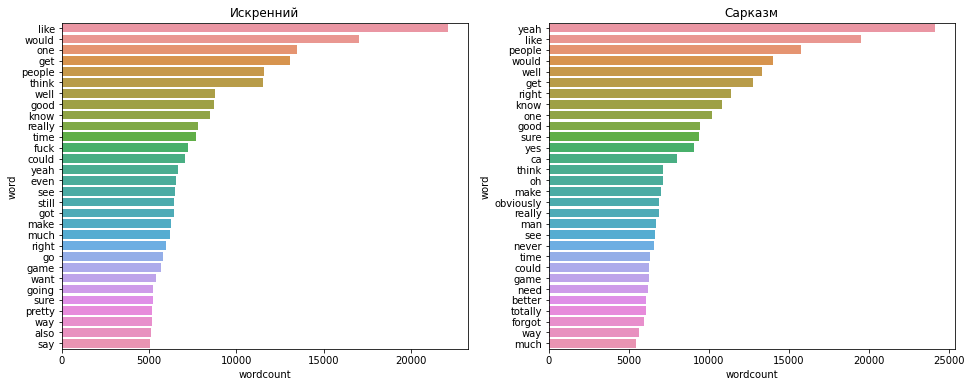

In [10]:
## Get the bar chart from sincere questions ##
freq_dict_0 = defaultdict(int)
for sent in train0_df:
    for word in generate_ngrams(sent):
        freq_dict_0[word] += 1
fd_sorted_0 = pd.DataFrame(sorted(freq_dict_0.items(), key=lambda x: x[1])[::-1])
fd_sorted_0.columns = ["word", "wordcount"]

print("half")

## Get the bar chart from insincere questions ##
freq_dict_1 = defaultdict(int)
for sent in train1_df:
    for word in generate_ngrams(sent):
        freq_dict_1[word] += 1
fd_sorted_1 = pd.DataFrame(sorted(freq_dict_1.items(), key=lambda x: x[1])[::-1])
fd_sorted_1.columns = ["word", "wordcount"]

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axes[0].title.set_text("Искренний")
axes[1].title.set_text("Сарказм")

sns.barplot(y="word", x="wordcount", data=fd_sorted_0.head(30), ax=axes[0])
sns.barplot(y="word", x="wordcount", data=fd_sorted_1.head(30), ax=axes[1])

half


<AxesSubplot:title={'center':'Сарказм'}, xlabel='wordcount', ylabel='word'>

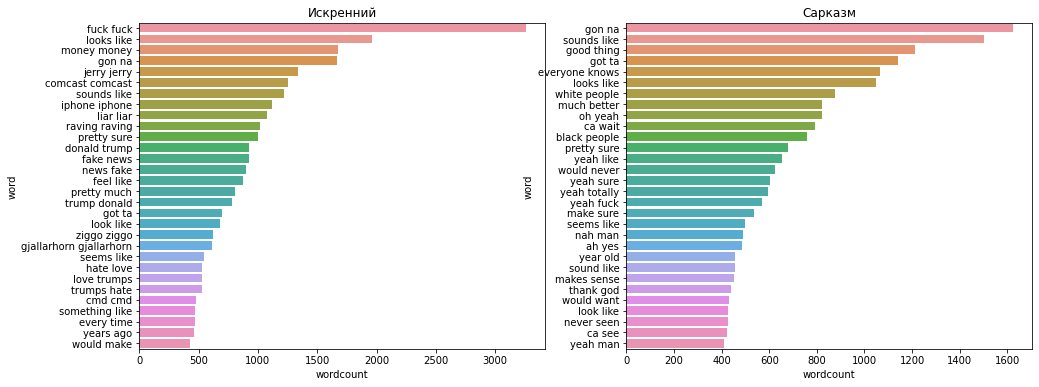

In [11]:
freq_dict_bi_0 = defaultdict(int)
for sent in train0_df:
    for word in generate_ngrams(sent, 2):
        freq_dict_bi_0[word] += 1
fd_bi_sorted_0 = pd.DataFrame(sorted(freq_dict_bi_0.items(), key=lambda x: x[1])[::-1])
fd_bi_sorted_0.columns = ["word", "wordcount"]

print("half")

## Get the bar chart from insincere questions ##
freq_dict_bi_1 = defaultdict(int)
for sent in train1_df:
    for word in generate_ngrams(sent, 2):
        freq_dict_bi_1[word] += 1
fd_bi_sorted_1 = pd.DataFrame(sorted(freq_dict_bi_1.items(), key=lambda x: x[1])[::-1])
fd_bi_sorted_1.columns = ["word", "wordcount"]

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axes[0].title.set_text("Искренний")
axes[1].title.set_text("Сарказм")

sns.barplot(y="word", x="wordcount", data=fd_bi_sorted_0.head(30), ax=axes[0])
sns.barplot(y="word", x="wordcount", data=fd_bi_sorted_1.head(30), ax=axes[1])

half


<AxesSubplot:title={'center':'Сарказм'}, xlabel='wordcount', ylabel='word'>

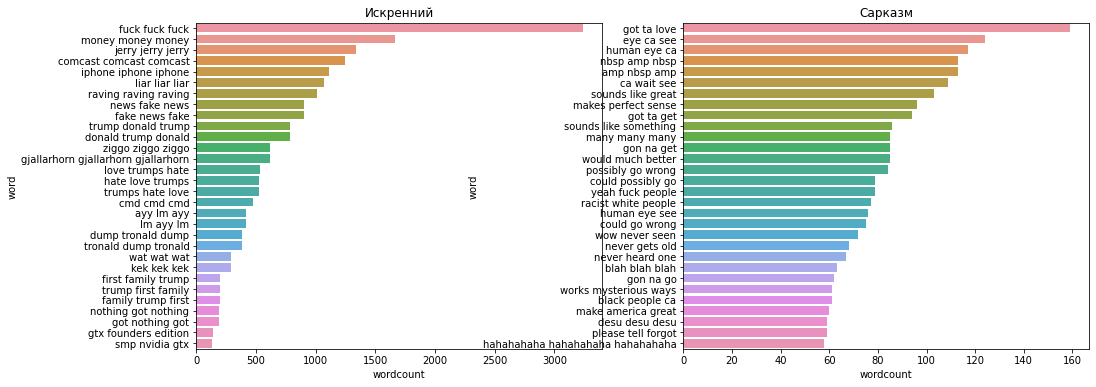

In [12]:
freq_dict_tri_0 = defaultdict(int)
for sent in train0_df:
    for word in generate_ngrams(sent, 3):
        freq_dict_tri_0[word] += 1
fd_tri_sorted_0 = pd.DataFrame(sorted(freq_dict_tri_0.items(), key=lambda x: x[1])[::-1])
fd_tri_sorted_0.columns = ["word", "wordcount"]

print("half")

## Get the bar chart from insincere questions ##
freq_dict_tri_1 = defaultdict(int)
for sent in train1_df:
    for word in generate_ngrams(sent, 3):
        freq_dict_tri_1[word] += 1
fd_tri_sorted_1 = pd.DataFrame(sorted(freq_dict_tri_1.items(), key=lambda x: x[1])[::-1])
fd_tri_sorted_1.columns = ["word", "wordcount"]

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axes[0].title.set_text("Искренний")
axes[1].title.set_text("Сарказм")

sns.barplot(y="word", x="wordcount", data=fd_tri_sorted_0.head(30), ax=axes[0])
sns.barplot(y="word", x="wordcount", data=fd_tri_sorted_1.head(30), ax=axes[1])

<AxesSubplot:>

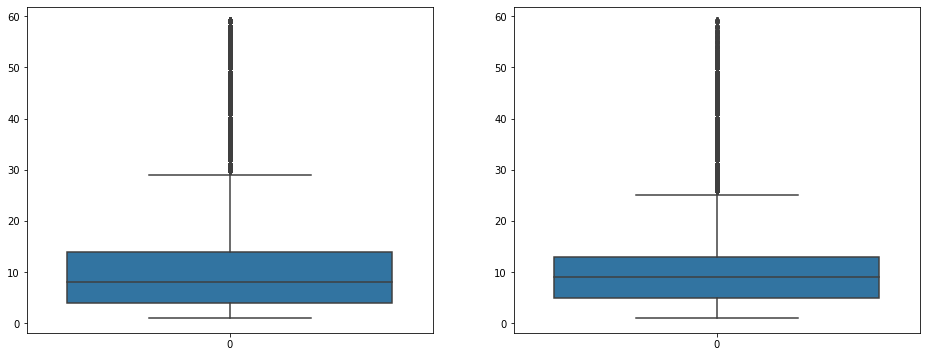

In [13]:
num_words_0 = train0_df.apply(lambda sent: len(sent.split()))
num_words_1 = train1_df.apply(lambda sent: len(sent.split()))

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6))

#sns.boxplot(x=y_train, y=train_texts.apply(lambda x: len(x.split())))
sns.boxplot(data=list(filter(lambda x: x < 60, num_words_0)), ax=axes[0])
sns.boxplot(data=list(filter(lambda x: x < 60, num_words_1)), ax=axes[1])

<AxesSubplot:>

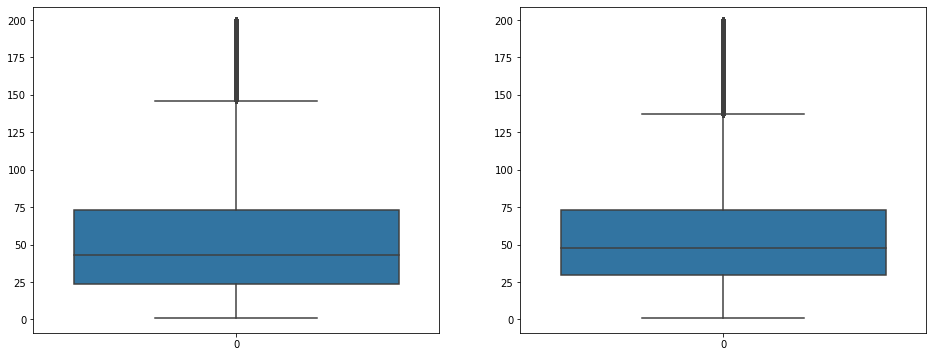

In [14]:
num_chars_0 = train0_df.apply(lambda sent: len(sent))
num_chars_1 = train1_df.apply(lambda sent: len(sent))

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6))

#sns.boxplot(x=y_train, y=train_texts.apply(lambda x: len(x.split())))
sns.boxplot(data=list(filter(lambda x: x < 200, num_chars_0)), ax=axes[0])
sns.boxplot(data=list(filter(lambda x: x < 200, num_chars_1)), ax=axes[1])

<AxesSubplot:>

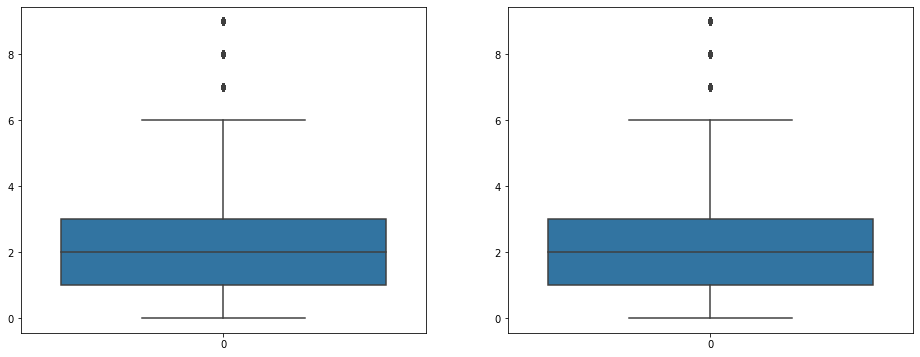

In [15]:
num_punct_0 = train0_df.apply(lambda sent: len([c for c in sent if c in string.punctuation]))
num_punct_1 = train1_df.apply(lambda sent: len([c for c in sent if c in string.punctuation]))

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6))

#sns.boxplot(x=y_train, y=train_texts.apply(lambda x: len(x.split())))
sns.boxplot(data=list(filter(lambda x: x < 10, num_punct_0)), ax=axes[0])
sns.boxplot(data=list(filter(lambda x: x < 10, num_punct_1)), ax=axes[1])

In [16]:
tf_idf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tf_idf_vec.fit_transform(train_texts.values.tolist() + valid_texts.values.tolist())
train_tf_idf = tf_idf_vec.transform(train_texts.values.tolist())
valid_tf_idf = tf_idf_vec.transform(valid_texts.values.tolist())

In [17]:
train_y = y_train.values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_tf_idf[dev_index], train_tf_idf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, valid_tf_idf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(log_loss(val_y, pred_val_y))
    break

Building model.


IndexError: index (1010771) out of range

In [ ]:
for thresh in np.arange(0.1, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score(val_y, (pred_val_y>thresh).astype(int))))

In [ ]:
import eli5

eli5.show_weights(model, vec=tf_idf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions